In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
def t_stats_tracks_in_vtxs(vertex_tracks_idx, track_t, v_zs):
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event, event_zs) in enumerate(zip(vertex_tracks_idx, v_zs)):
        event_avg_t = []
        event_rms_t = []
        event_stat_zs = []
        
        for vertex_tracks, z in zip(event, event_zs):
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
                event_stat_zs.append(z)
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
        stat_zs.append(event_stat_zs)
    return np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')

def t_stats_tracks_in_jets(vertex_tracks_idx, track_t):
    avg_ts = []
    rms_ts = []
    
    for i, event in enumerate(vertex_tracks_idx):
        event_avg_t = []
        event_rms_t = []
        for vertex_tracks in event:
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
    return np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object')

In [44]:
files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
track_t = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')
jet_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            jet_track_idxs = np.concatenate((jet_track_idxs, tree['jet_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))

In [11]:
track_t_flat = flatten_array(track_t)
track_t30_flat = flatten_array(track_t30)
track_t90_flat = flatten_array(track_t90)
track_t180_flat = flatten_array(track_t180)

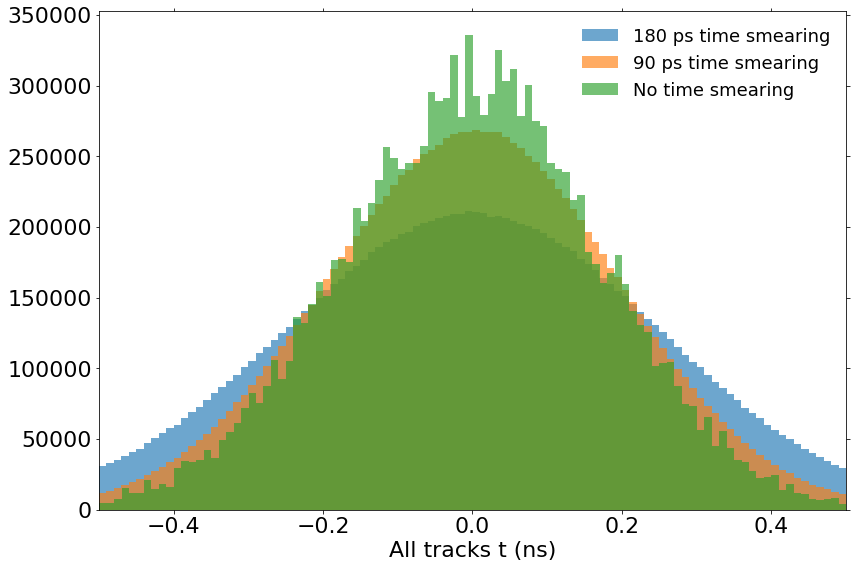

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

t_max = 0.5

idx   = np.abs(track_t_flat) < t_max
idx30 = np.abs(track_t30_flat) < t_max
idx90 = np.abs(track_t90_flat) < t_max
idx180 = np.abs(track_t180_flat) < t_max

_ = ax.hist(track_t180_flat[idx180], bins=100, alpha=0.65, density=False, label='180 ps time smearing')
_ = ax.hist(track_t90_flat [idx90],  bins=100, alpha=0.65, density=False, label='90 ps time smearing')
_ = ax.hist(track_t_flat   [idx],    bins=100, alpha=0.65, density=False, label='No time smearing')

ax.legend(frameon=False)
ax.set_xlabel('All tracks t (ns)')
ax.set_xlim(-t_max, t_max)
fig.tight_layout()

In [30]:
rev_avg_ts, rev_rms_ts, rev_stat_z = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t, reco_vertex_z)
trv_avg_ts, trv_rms_ts, trv_stat_z = t_stats_tracks_in_vtxs(truth_vertex_track_idxs, track_t, truth_vertex_z)

jet_avg_ts, jet_rms_ts = t_stats_tracks_in_jets(jet_track_idxs, track_t)

rev_avg_ts_flat = flatten_array(rev_avg_ts)
trv_avg_ts_flat = flatten_array(trv_avg_ts)
jet_avg_ts_flat = flatten_array(jet_avg_ts)

rev_rms_ts_flat = flatten_array(rev_rms_ts)
trv_rms_ts_flat = flatten_array(trv_rms_ts)
jet_rms_ts_flat = flatten_array(jet_rms_ts)

rev_stat_z_flat = flatten_array(rev_stat_z)
trv_stat_z_flat = flatten_array(trv_stat_z)

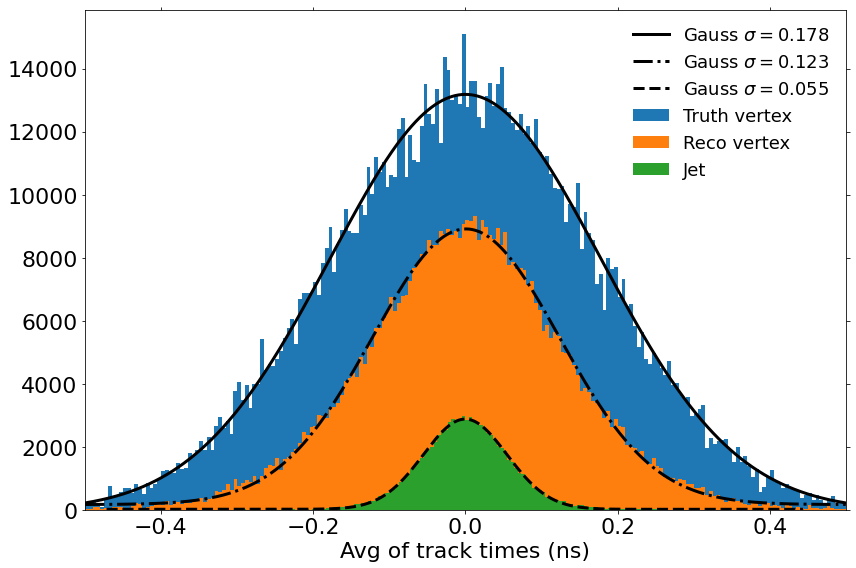

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

t_range = 0.5

bin_heights_trv, bin_borders_trv, _ = ax.hist(trv_avg_ts_flat[np.abs(trv_avg_ts_flat) < t_range], bins = 200, label='Truth vertex')
bin_heights_rev, bin_borders_rev, _ = ax.hist(rev_avg_ts_flat[np.abs(rev_avg_ts_flat) < t_range], bins = 200, label='Reco vertex')
bin_heights_jet, bin_borders_jet, _ = ax.hist(jet_avg_ts_flat[np.abs(jet_avg_ts_flat) < t_range], bins = 200, label='Jet')

bin_centers_trv = bin_borders_trv[:-1] + np.diff(bin_borders_trv) / 2
bin_centers_rev = bin_borders_rev[:-1] + np.diff(bin_borders_rev) / 2
bin_centers_jet = bin_borders_jet[:-1] + np.diff(bin_borders_jet) / 2
popt_trv, _ = curve_fit(gaussian, bin_centers_trv, bin_heights_trv, p0=[2500., 0., 0.1, 0])
popt_rev, _ = curve_fit(gaussian, bin_centers_rev, bin_heights_rev, p0=[2500., 0., 0.1, 0])
popt_jet, _ = curve_fit(gaussian, bin_centers_jet, bin_heights_jet, p0=[2500., 0., 0.1, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders_trv[0], bin_borders_trv[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt_trv), 'k-', lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt_trv[2])), zorder=10)

x_interval_for_fit = np.linspace(bin_borders_rev[0], bin_borders_rev[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt_rev), 'k-.', lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt_rev[2])), zorder=10)

x_interval_for_fit = np.linspace(bin_borders_jet[0], bin_borders_jet[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt_jet), 'k--', lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt_jet[2])), zorder=10)


ax.set_xlabel('Avg of track times (ns)')
ax.set_xlim(-t_range, t_range)
# plt.yscale('log')
ax.legend(frameon=False)

fig.tight_layout()

In [70]:
## TODO
## Reco vertex track times (with smearing) vs truth - only consider reco with sumpt2 > 15^2 GeV^2?
def t_stats_tracks_in_vtxs_new(track_t, vertex_tracks_idx, vertex_zs, vertex_sumPt2, sumPt2_min):
    all_ts = []
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event_vertex_track_idx, event_vertex_zs, event_vertex_sumPt2) in enumerate(zip(vertex_tracks_idx, vertex_zs, vertex_sumPt2)):
        event_all_ts = []
        event_avg_t = []
        event_rms_t = []
        event_stat_zs = []
        
        hard_enough_vertex_idx = event_vertex_sumPt2 > sumPt2_min
        
        for vertex_tracks, z in zip(event_vertex_track_idx[hard_enough_vertex_idx], event_vertex_zs[hard_enough_vertex_idx]):
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                event_all_ts.append(ts)
                
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
                event_stat_zs.append(z)
        avg_ts.append (np.array(event_avg_t))
        rms_ts.append (np.array(event_rms_t))
        stat_zs.append(np.array(event_stat_zs))
        all_ts.append (np.array(event_all_ts))
    return np.array(all_ts, dtype='object'), np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')
    
def t_stats_tracks_in_HS_vtxs(track_t, vertex_tracks_idx, vertex_zs):
    all_ts = []
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event_vertex_track_idx, event_vertex_zs) in enumerate(zip(vertex_tracks_idx, vertex_zs)):
        event_all_ts = []
        event_avg_t = []
        event_rms_t = []
        event_stat_zs = []
        
        vertex_tracks = event_vertex_track_idx[0]
        z = event_vertex_zs[0]
        if len(vertex_tracks) > 0:
            ts = np.array(track_t[i][vertex_tracks])
            event_all_ts = ts
            
            avg_t = np.mean(ts)
            rms_t = np.sqrt(np.mean(ts**2))
            event_avg_t = avg_t
            event_rms_t = rms_t
            event_stat_zs = z
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
        stat_zs.append(event_stat_zs)
        all_ts.append(event_all_ts)
    
    return np.array(all_ts, dtype='object'), np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')

In [96]:
rev_all_ts, rev_avg_ts, rev_rms_ts, rev_stat_z              = t_stats_tracks_in_vtxs_new(track_t, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)
rev_all_ts30, rev_avg_ts30, rev_rms_ts30, rev_stat_z30      = t_stats_tracks_in_vtxs_new(track_t30, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)
rev_all_ts90, rev_avg_ts90, rev_rms_ts90, rev_stat_z90      = t_stats_tracks_in_vtxs_new(track_t90, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)
rev_all_ts180, rev_avg_ts180, rev_rms_ts180, rev_stat_z180  = t_stats_tracks_in_vtxs_new(track_t180, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)

rev_all_ts_flat = flatten_array(rev_all_ts)
rev_all_ts30_flat = flatten_array(rev_all_ts30)
rev_all_ts90_flat = flatten_array(rev_all_ts90)
rev_all_ts180_flat = flatten_array(rev_all_ts180)

rev_avg_ts_flat = flatten_array(rev_avg_ts)
rev_avg_ts30_flat = flatten_array(rev_avg_ts30)
rev_avg_ts90_flat = flatten_array(rev_avg_ts90)
rev_avg_ts180_flat = flatten_array(rev_avg_ts180)

rev_rms_ts_flat = flatten_array(rev_rms_ts)
rev_rms_ts30_flat = flatten_array(rev_rms_ts30)
rev_rms_ts90_flat = flatten_array(rev_rms_ts90)
rev_rms_ts180_flat = flatten_array(rev_rms_ts180)

rev_stat_z_flat = flatten_array(rev_stat_z)
rev_stat_z30_flat = flatten_array(rev_stat_z30)
rev_stat_z90_flat = flatten_array(rev_stat_z90)
rev_stat_z180_flat = flatten_array(rev_stat_z180)

<ipython-input-70-7469ea8cde3a>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_ts.append (np.array(event_all_ts))


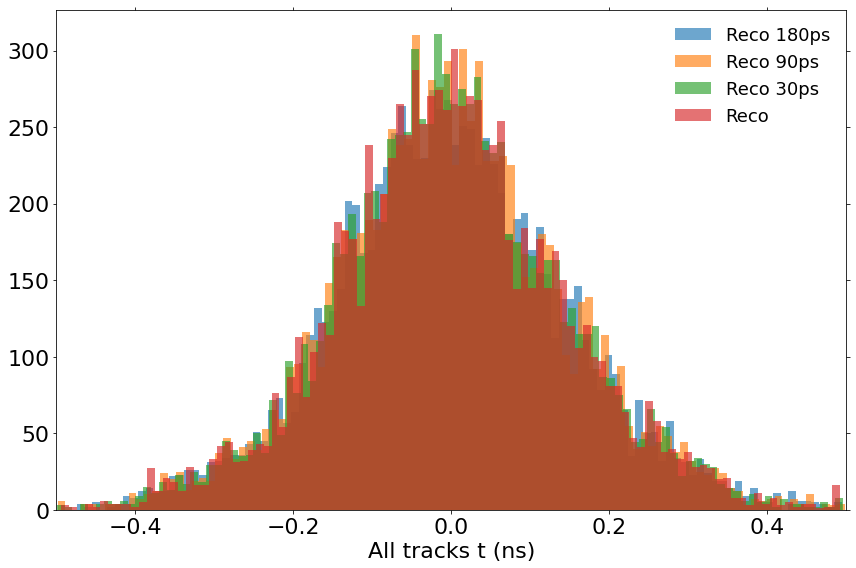

In [98]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

t_max = 0.5

idx_rev = np.abs(rev_avg_ts_flat) < t_max
idx_rev30 = np.abs(rev_avg_ts30_flat) < t_max
idx_rev90 = np.abs(rev_avg_ts90_flat) < t_max
idx_rev180 = np.abs(rev_avg_ts180_flat) < t_max

# idx_trv = np.abs(trv_avg_ts_flat) < t_max


_ = ax.hist(rev_avg_ts180_flat[idx_rev180], bins=100, alpha=0.65, density=False, label='Reco 180ps')
_ = ax.hist(rev_avg_ts90_flat[idx_rev90], bins=100, alpha=0.65, density=False, label='Reco 90ps')
_ = ax.hist(rev_avg_ts30_flat[idx_rev30], bins=100, alpha=0.65, density=False, label='Reco 30ps')
_ = ax.hist(rev_avg_ts_flat[idx_rev], bins=100, alpha=0.65, density=False, label='Reco')

# _ = ax.hist(trv_avg_ts_flat[idx_trv],  bins=100, alpha=0.65, density=False, label='Truth')

ax.legend(frameon=False)
ax.set_xlabel('All tracks t (ns)')
ax.set_xlim(-t_max, t_max)
fig.tight_layout()

In [95]:
truth_vertex_track_idxs[100][50], reco_vertex_track_idxs[0][0]

(<STLVector [482] at 0x7f4c90448070>,
 <STLVector [75, 142, 404, 541, 590, ..., 1631, 1670, 1677, 1703] at 0x7f4c7305d760>)

In [ ]:
## Plot t or avg t of tracks belonging to verteces

(array([ 25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 183.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

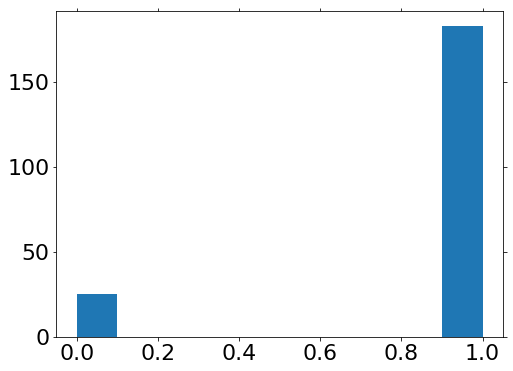

In [91]:
lens = []
for idxs in truth_vertex_track_idxs[0]:
    lens.append(len(idxs))

plt.hist(lens)

(array([14., 33., 22., 10.,  5.,  6.,  2.,  3.,  1.,  2.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ]),
 <BarContainer object of 10 artists>)

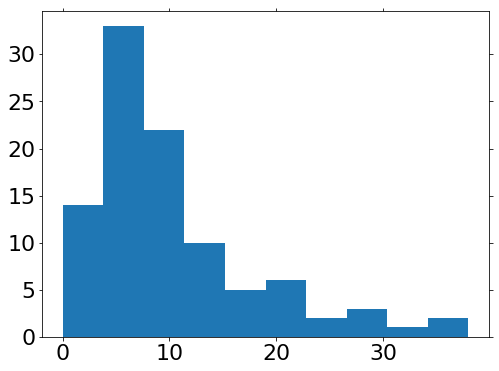

In [92]:
lens = []
for idxs in reco_vertex_track_idxs[0]:
    lens.append(len(idxs))

plt.hist(lens)